In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import math

import sys 
sys.path.append('..')
from functions import *
# from colormaps import new_colors
cmap = plt.get_cmap('tab10')
new_colors = cmap(range(10))

3.0rc1


In [3]:
def weighted_avg_and_std(values, weights):
    import math
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def plot_sigma_slope(run):
    
    file_name = '/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/outfiles/cosmos_bplanck_run_{0}.hdf5'.format(str(run))
    reader = emcee.backends.HDFBackend(file_name)
    
#     tau = reader.get_autocorr_time()
#     burnin = int(2*np.max(tau))
#     thin = int(0.5*np.min(tau))


    burnin = 4000
    thin = 1


    chains = reader.get_chain()
    log_prob = reader.get_log_prob()
    
    print("burn-in: {0}".format(burnin))
    print("thin: {0}".format(thin))
    print('{0} walkers'.format(chains.shape[1]))
    print('{0} iterations per walker so far ({1} total)'.format(chains.shape[0],
                                                                chains.shape[0]*chains.shape[1]))
    
    chains = reader.get_chain(discard=burnin, flat=True, thin=thin)
    log_prob = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
    print('{0} iterations being used total'.format(chains.shape[0]))

    #only first 2 params
    sigma_2, sigma_3 =  chains.T[:2]

    #flatten walker chains together
    sigma_2_flat, sigma_3_flat = sigma_2.T.flatten(), sigma_3.T.flatten()

    #get means and sigmas
    mean_sigma2, std_sigma2 = weighted_avg_and_std(sigma_2_flat, np.exp(log_prob))
    mean_sigma3, std_sigma3 = weighted_avg_and_std(sigma_3_flat, np.exp(log_prob))

    #plot
    fig, axes=plt.subplots(1,2, figsize=[15,6])
    
    #left subplot: Vmax@Mpeak
    axes[0].errorbar([2,3], [mean_sigma2, mean_sigma3],yerr=[std_sigma2, std_sigma3],
            c=plt.get_cmap('tab20')(0), linewidth=3, linestyle='--', marker='o', label = 'model')
    axes[0].fill_between([2,3], [mean_sigma2+std_sigma2, mean_sigma3+std_sigma3],
                     [mean_sigma2-std_sigma2,  mean_sigma3-std_sigma3],
                     color=plt.get_cmap('tab20')(0), alpha=0.3)

    axes[0].set_xlabel(r'$\log(V_{max}@M_{peak}$)', fontsize=25)
    axes[0].set_ylabel(r'$\sigma_{M_* | V_{max}@M_{peak}}$', fontsize=25)
    axes[0].legend()
    
    #right subplot: mvir
    axes[1].scatter(bin_centers, binned_scatter, marker='+', color=plt.get_cmap('tab20')(0),
                 label = 'model', linewidth=3)
#     axes[1].errorbar([10,13], [mean_sigma2, mean_sigma3],yerr=[std_sigma2, std_sigma3],
#             c=plt.get_cmap('tab20')(0), linewidth=3, linestyle='--', marker='o', label = 'model')
#     axes[1].fill_between([10,13], [mean_sigma2+std_sigma2, mean_sigma3+std_sigma3],
#                      [mean_sigma2-std_sigma2,  mean_sigma3-std_sigma3],
#                      color=plt.get_cmap('tab20')(0), alpha=0.3)
    
    GK = lambda Mhalo, M1: 0.2 - (0.26*(Mhalo-M1))
    Munshi = lambda Mhalo: GK(Mhalo,9.7) if Mhalo<9.7 else 0.1
    Wasserman = lambda Mhalo: GK(Mhalo,11.5) if Mhalo<11.5 else 0.2
    x = np.array([10,11.5, 13])
    axes[1].plot(x, [Munshi(xi)for xi in x], c=plt.get_cmap('tab20')(2), linewidth=3, linestyle='--', marker='o',
                 label = 'Munshi+2017')
    axes[1].plot(x, [Wasserman(xi) for xi in x], c=plt.get_cmap('tab20')(4), linewidth=3, linestyle='--', marker='o',
                 label = 'Wasserman+2018')
    

    axes[1].set_xlabel(r'$\log(M_{vir}$)', fontsize=25)
    axes[1].set_ylabel(r'$\sigma_{M_* | M_{vir}}$', fontsize=25)
    axes[1].legend()

    plt.show()

In [4]:
run='Vmax_4'

config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
config, cosmos_data, sim_data = initial_model(config)

5SHMR+scatter (Vmax@Mpeak)


In [5]:
best_params = [ 0.53903687,  0.11330591,  2.72161542, 11.01133551,  0.11815845,  0.70730249,  0.28967114]

In [6]:
stellar_masses = get_chris_stellar_masses(best_params, config, sim_data)
halo_data = sim_data['halocat'].halo_table
halo_data['M_*'] = 10**stellar_masses

## plot sigma function

In [7]:
n_bins=20
bins=np.linspace(10,13,n_bins)
dx = bins[1]-bins[0]
bin_centers = bins[:-1]+dx/2.

halo_data_10_13 = halo_data[(halo_data['halo_mvir']>1e9) & (halo_data['halo_mvir']<1e14)]
binned_scatter, _, _ = binned_statistic(np.log10(halo_data_10_13['halo_mvir']),np.log10(halo_data_10_13['M_*']), 
                                  bins=bins, statistic=lambda x: np.std(x))

/Users/fardila/anaconda/envs/dwarf_lensing/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [136]:
binned_scatter

array([0.90936983, 0.87827043, 0.83855767, 0.80110256, 0.76807016,
       0.72539045, 0.67897231, 0.63056283, 0.58090089, 0.53918965,
       0.50341457, 0.46570288, 0.44433129, 0.41468271, 0.39469153,
       0.37250117, 0.34866831, 0.32334291, 0.30624798])

burn-in: 4000
thin: 1
15 walkers
10000 iterations per walker so far (150000 total)
90000 iterations being used total


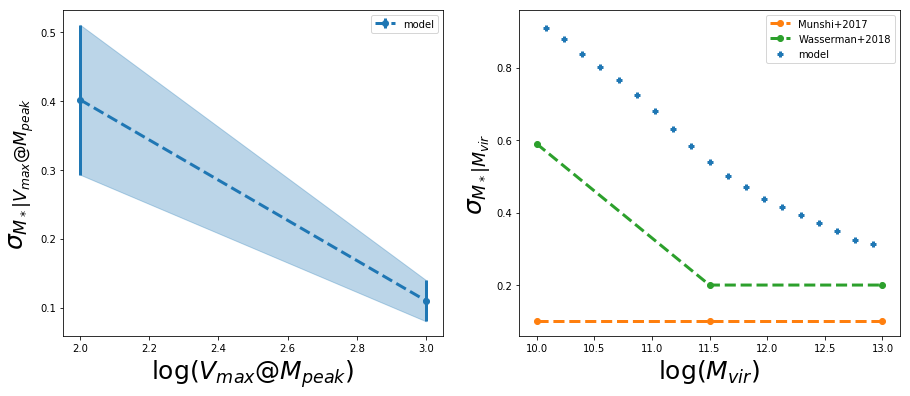

In [25]:
run='Vmax_4'
plot_sigma_slope(run)

## make catalog of all galaxies for alexie

In [8]:
halo_data_reduced = halo_data['M_*','halo_mpeak','halo_mvir','halo_Vmax@Mpeak', 'halo_pid']
halo_data_reduced.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_full_catalog.ascii',
                  format ='ascii', overwrite=True, comment='#'  )



## making catalog of low mass galaxies with best fit params

stellar masses around 2x10^8 Msun

send Alexie a catalog of these objects with : M*, Mhalo, Mpeak, vMax@mpeak

In [56]:
dwarf_mass = np.log10(2e8)
dwarf_halos = halo_data[(np.log10(halo_data['M_*'])>dwarf_mass-0.01) & (np.log10(halo_data['M_*'])<dwarf_mass+0.01)]

In [57]:
dwarf_halos

halo_upid,halo_y,halo_x,halo_z,halo_Vmax@Mpeak,halo_rvir,halo_vy,halo_id,halo_vx,halo_mpeak,halo_vz,halo_mvir,halo_hostid,halo_mvir_host_halo,M_*
int64,float32,float32,float32,float64,float32,float32,int64,float32,float32,float32,float32,int64,float32,float64
2404371171,42.46758,36.31219,18.73313,92.82,0.041286997,-400.74,2404371659,-20.93,48970000000.0,191.32,6509000000.0,2404371171,162700000000000.0,8.295252853172773
2402455808,13.49677,21.82855,10.31479,78.57,0.038479,-18.81,2402456076,-663.6,23560000000.0,436.6,5269000000.0,2402455808,119200000000000.0,8.294212778657263
2402481157,25.03206,15.76387,24.31598,79.38,0.040279,-110.16,2402481322,-925.65,35950000000.0,262.85,6044000000.0,2402481157,70480000000000.0,8.302581457767442
2402481668,27.64672,4.03123,22.59529,55.95,0.036905997,222.71,2402481740,-199.82,12240000000.0,-58.91,4649000000.0,2402481668,32670000000000.0,8.3017348973843
2402471181,18.30066,13.31102,14.08953,67.53,0.032241,127.7,2402471202,240.34,14260000000.0,52.68,3099000000.0,2402471181,18270000000000.0,8.304020621077418
2404384064,44.71968,42.50826,39.70943,85.19,0.035867,570.7,2404384080,623.94,44320000000.0,-148.11,4261000000.0,2404384064,17710000000000.0,8.29769067012952
2402670473,34.99328,26.66337,4.76281,80.44,0.035187,-243.27,2402670496,298.8,27430000000.0,519.89,4029000000.0,2402670473,10860000000000.0,8.309039854993358
2402671391,41.33159,16.63626,7.10704,91.08,0.028627,-159.88,2402671392,-206.59,49740000000.0,26.57,2169000000.0,2402671391,5755000000000.0,8.308160428092185
2402458695,17.76208,31.16812,9.05085,67.65,0.047757,20.07,2402458701,-317.17,35020000000.0,-241.6,10070000000.0,2402458695,4523000000000.0,8.296480496114857


In [39]:
dwarf_halos.keys()

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_Vmax@Mpeak',
 'halo_rvir',
 'halo_vy',
 'halo_id',
 'halo_vx',
 'halo_mpeak',
 'halo_vz',
 'halo_mvir',
 'halo_hostid',
 'halo_mvir_host_halo',
 'M_*']

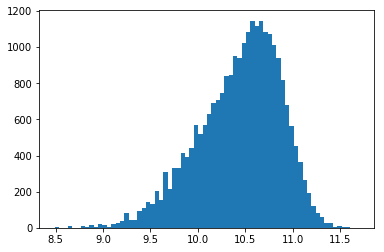

In [23]:
plt.hist(np.log10(dwarf_halos['halo_mvir']), bins=70)
plt.xlim
plt.show()

In [35]:
dwarf_halos.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_catalog.hdf5',
                  path ='catalog', overwrite=True )



In [59]:
dwarf_halos_reduced = dwarf_halos['halo_mvir','halo_mpeak','halo_Vmax@Mpeak','M_*']
dwarf_halos_reduced.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_catalog_short.ascii',
                  format ='ascii', overwrite=True, comment='#' )



In [8]:
def make_catalog_given_params(params, run, config = None, cosmos_data = None, sim_data = None, 
                              reduced=False, write=False):

    if not config:
        config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
        config, cosmos_data, sim_data = initial_model(config)

    halo_data = sim_data['halocat'].halo_table
    
    stellar_masses = get_chris_stellar_masses(params, config, sim_data)
    halo_data['M_*'] = 10**stellar_masses
    
    if reduced:
        halo_data = halo_data['M_*','halo_mpeak','halo_mvir','halo_Vmax@Mpeak', 'halo_upid']
    
    if write:
        halo_data.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_{0}.ascii'.format(run),
                  format ='ascii', overwrite=True, comment='#')
    
    return halo_data


In [15]:
best_params_no_orphans = [ 0.48418425,  0.11010146,  2.72603396, 11.03541275,  0.11999312,  0.90875961, -0.01469141]
best_params_orphans = [ 0.31778976,  0.16864865,  2.76285812, 11.15042856,  0.12689323,  0.96288237, -0.03033116]


In [16]:
make_catalog_given_params(best_params_no_orphans, 'Vmax_5')

5SHMR+scatter (Vmax@Mpeak)
['halo_upid', 'halo_y', 'halo_x', 'halo_z', 'halo_Vmax@Mpeak', 'halo_rvir', 'halo_vy', 'halo_id', 'halo_vx', 'halo_mpeak', 'halo_vz', 'halo_mvir', 'halo_hostid', 'halo_mvir_host_halo']


In [18]:
make_catalog_given_params(best_params_orphans, 'UM_1')

5SHMR+scatter (Vmax@Mpeak)


## make distributions of M_halo

In [10]:
burnin = 1
thin = 1

run = 'UM_1'
config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
config, cosmos_data, sim_data = initial_model(config)


file_name = '/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/outfiles/UM_cosmos_bplanck_run_{0}.hdf5'.format(str(run))
reader = emcee.backends.HDFBackend(file_name)

samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob = reader.get_log_prob(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

print('{0} iterations being used total'.format(samples.shape[0]))

5SHMR+scatter (Vmax@Mpeak)
burn-in: 1
thin: 1
161415 iterations being used total


In [64]:
len(samples)

158955

In [6]:
outfile = '/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/notebooks/Mpeak_distributions/Mpeak_distribution.npz'

In [ ]:
mpeak_bins=np.arange(9.5,12.3,0.05)
array_bin_values_8 = []
array_bin_values_9 = []

for i, sample in enumerate(samples[-5000:]):

        
    catalog = make_catalog_given_params(sample, run,
                                        config = config, cosmos_data = cosmos_data, sim_data = sim_data,
                                        write=False)
    catalog = catalog[(np.log10(catalog['M_*'])>7.8) & (np.log10(catalog['M_*'])<9.2)]


    m_star8_catalog = catalog[(np.log10(catalog['M_*'])>7.9) & (np.log10(catalog['M_*'])<8.1)]
    m_star9_catalog = catalog[(np.log10(catalog['M_*'])>8.9) & (np.log10(catalog['M_*'])<9.1)]

    bin_values_8, _ = np.histogram(np.log10(m_star8_catalog['halo_mpeak']), bins=mpeak_bins, density = True)
    bin_values_9, _ = np.histogram(np.log10(m_star9_catalog['halo_mpeak']), bins=mpeak_bins, density = True)

    array_bin_values_8.append(bin_values_8)
    array_bin_values_9.append(bin_values_9)
    
        
    if i%100 == 0 :
        print 'Sample: ', i
        
        np.savez(outfile, mpeak_bins=mpeak_bins, 
                          array_bin_values_8=array_bin_values_8,
                          array_bin_values_9=array_bin_values_9 )

array_bin_values_8 = np.array(array_bin_values_8)
array_bin_values_9 =  np.array(array_bin_values_9)

Sample:  0
Sample:  100
Sample:  200
Sample:  300


In [47]:
arr = np.load(outfile)
array_bin_values_8 = arr['array_bin_values_8']
array_bin_values_9 = arr['array_bin_values_9']
mpeak_bins = arr['mpeak_bins']

In [48]:
n=len(array_bin_values_9)
print(n)

1300


In [49]:
weighted_means_8 = np.array([weighted_avg_and_std(array_bin_values_8[:,bin], np.exp(log_prob[-5000:-5000+n]))[0] for bin in range(len(mpeak_bins)-1)])
weighted_stds_8 = np.array([weighted_avg_and_std(array_bin_values_8[:,bin], np.exp(log_prob[-5000:-5000+n]))[1] for bin in range(len(mpeak_bins)-1)])

weighted_means_9 = np.array([weighted_avg_and_std(array_bin_values_9[:,bin], np.exp(log_prob[-5000:-5000+n]))[0] for bin in range(len(mpeak_bins)-1)])
weighted_stds_9 = np.array([weighted_avg_and_std(array_bin_values_9[:,bin], np.exp(log_prob[-5000:-5000+n]))[1] for bin in range(len(mpeak_bins)-1)])



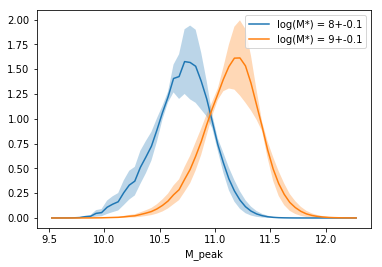

In [50]:
mpeak_bins_centers = mpeak_bins[:-1]+((mpeak_bins[1]-mpeak_bins[0])/2.)
# plt.errorbar(mpeak_bins_centers, weighted_means_8, yerr=weighted_stds_8 )
# plt.errorbar(mpeak_bins_centers, weighted_means_9, yerr=weighted_stds_9 )

plt.plot(mpeak_bins_centers, weighted_means_8, label='log(M*) = 8+-0.1')
plt.plot(mpeak_bins_centers, weighted_means_9, label='log(M*) = 9+-0.1')

plt.fill_between(mpeak_bins_centers, weighted_means_8+weighted_stds_8, weighted_means_8-weighted_stds_8, alpha=0.3)
plt.fill_between(mpeak_bins_centers, weighted_means_9+weighted_stds_9, weighted_means_9-weighted_stds_9, alpha=0.3)

plt.xlabel('M_peak')
plt.legend()

In [51]:
np.savetxt('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/notebooks/M_peak_distributions/M_peak_distributions.txt',
           np.c_[mpeak_bins_centers,weighted_means_8, weighted_stds_8, weighted_means_9, weighted_stds_9 ],
           header = 'Mpeak_bin(M_sun) mean_M*8 std_M*8 mean_M*9 std_M*9')

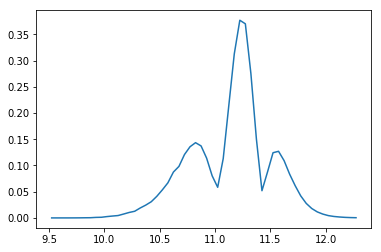

In [36]:
plt.plot(mpeak_bins_centers,weighted_stds_9)

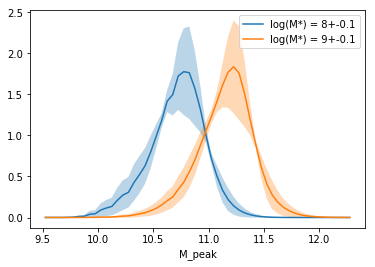

In [14]:
mpeak_bins_centers = mpeak_bins[:-1]+((mpeak_bins[1]-mpeak_bins[0])/2.)
# plt.errorbar(mpeak_bins_centers, weighted_means_8, yerr=weighted_stds_8 )
# plt.errorbar(mpeak_bins_centers, weighted_means_9, yerr=weighted_stds_9 )

plt.plot(mpeak_bins_centers, weighted_means_8, label='log(M*) = 8+-0.1')
plt.plot(mpeak_bins_centers, weighted_means_9, label='log(M*) = 9+-0.1')

plt.fill_between(mpeak_bins_centers, weighted_means_8+weighted_stds_8, weighted_means_8-weighted_stds_8, alpha=0.3)
plt.fill_between(mpeak_bins_centers, weighted_means_9+weighted_stds_9, weighted_means_9-weighted_stds_9, alpha=0.3)

plt.xlabel('M_peak')
plt.legend()

(array([0.00000000e+00, 0.00000000e+00, 1.39200156e-04, 4.87200546e-04,
        1.60080179e-03, 4.55880511e-03, 1.16928131e-02, 2.56476287e-02,
        5.63064631e-02, 1.03878116e-01, 1.91121814e-01, 3.35785576e-01,
        5.34632999e-01, 7.92744888e-01, 1.06272359e+00, 1.27709183e+00,
        1.37996075e+00, 1.31679867e+00, 1.10069043e+00, 8.09692507e-01,
        4.99519759e-01, 2.71823104e-01, 1.32831749e-01, 5.64804633e-02,
        2.21328248e-02, 8.03880900e-03, 2.54040285e-03, 1.07880121e-03]),
 array([ 9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5,
        10.6, 10.7, 10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6,
        11.7, 11.8, 11.9, 12. , 12.1, 12.2, 12.3]),
 <a list of 28 Patch objects>)

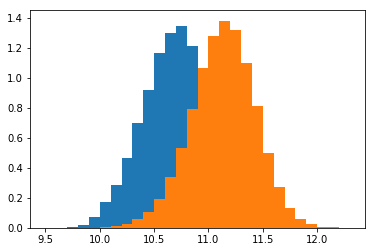

In [36]:
plt.hist(np.log10(m_star8_catalog['halo_mpeak']), bins=mpeak_bins, density = True)
plt.hist(np.log10(m_star9_catalog['halo_mpeak']), bins=mpeak_bins, density = True)

## Mpeak distribution for Asher 

In [42]:
best_UM_params = [ 0.31778976, 0.16864865, 2.76285812, 11.15042856,  0.12689323,  0.96288237, -0.03033116]
UM_catalog = make_catalog_given_params(sample, run,
                                        config = config, cosmos_data = cosmos_data, sim_data = sim_data,
                                        write=False)

In [44]:
run='UM_1'
UM_catalog.write('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_{0}.ascii'.format(run),
                  format ='ascii', overwrite=True, comment='#')

## mean radius and mass 

In [4]:
from astropy.io import ascii
from colossus.halo import mass_adv
from colossus.cosmology import cosmology

cosmo = cosmology.setCosmology('planck18')

In [5]:
cosmo.h

0.6766

In [6]:
mock = '/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/best_fit_mock_full_catalog.ascii'
ascii.read(mock)

M_*,halo_mpeak,halo_mvir,halo_Vmax@Mpeak,halo_pid
float64,float64,float64,float64,int64
137375224669.13655,162700004950016.0,162700004950016.0,999.86,-1
688006.5676522122,6818999808.0,4959000064.0,40.06,2404371171
61047.49465174735,5888999936.0,4028999936.0,35.48,2404371171
1474534.6551185967,5734000128.0,2788999936.0,39.84,2404371171
18459.94762999465,3254000128.0,2324000000.0,30.83,2404371171
900276537.1958504,73759997952.0,1084999936.0,119.86,2404371171
171248.25917812609,1084999936.0,929800000.0,19.03,2404371171
574828.4373561951,4959000064.0,929800000.0,43.93,2404371171
509648.9647360801,929800000.0,619900032.0,17.54,2404371171


In [9]:
run='UM_1'
best_UM_params = [ 0.31778976, 0.16864865, 2.76285812, 11.15042856,  0.12689323,  0.96288237, -0.03033116]
UM_catalog = make_catalog_given_params(best_UM_params, run,
                                        write=False)

5SHMR+scatter (Vmax@Mpeak)


In [10]:
catalog = UM_catalog[(np.log10(UM_catalog['M_*'])>7.8) & (np.log10(UM_catalog['M_*'])<9.2)]


m_star8_catalog = catalog[(np.log10(catalog['M_*'])>7.9) & (np.log10(catalog['M_*'])<8.1)]
m_star8p5_catalog = catalog[(np.log10(catalog['M_*'])>8.4) & (np.log10(catalog['M_*'])<8.6)]
m_star9_catalog = catalog[(np.log10(catalog['M_*'])>8.9) & (np.log10(catalog['M_*'])<9.1)]

In [8]:
catalog.keys()

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_Vmax@Mpeak',
 'halo_rvir',
 'halo_vy',
 'halo_id',
 'halo_vx',
 'halo_mpeak',
 'halo_vz',
 'halo_mvir',
 'halo_hostid',
 'halo_mvir_host_halo',
 'M_*']

In [11]:
a = 0.78209
h = 0.678
z = 0.278625

In [38]:
print('mean M_vir: {0} (M8), {1} (M9)'.format(np.mean(np.log10(m_star8_catalog['halo_mvir'])),
                                              np.mean(np.log10(m_star9_catalog['halo_mvir']))))

mean M_vir: 10.5476484299 (M8), 10.8946743011 (M9)


In [39]:
print('mean M_peak: {0} (M8), {1} (M9)'.format(np.mean(np.log10(m_star8_catalog['halo_mpeak'])),
                                              np.mean(np.log10(m_star9_catalog['halo_mpeak']))))

mean M_peak: 10.7222795486 (M8), 11.1591911316 (M9)


In [36]:
print('mean R_vir: {0} (M8), {1} (M9)'.format(np.mean(m_star8_catalog['halo_rvir']*a/h),
                                              np.mean(m_star9_catalog['halo_rvir']*a/h)))

mean R_vir: 0.0766932666302 (M8), 0.102970555425 (M9)


Originally:

Mvir: Halo mass (Msun).

Rvir: Halo radius (kpc/h comoving).

### convert to R200 

In [12]:
#use thinner slices so it doesn't take too long
m_star8_catalog = catalog[(np.log10(catalog['M_*'])>7.99) & (np.log10(catalog['M_*'])<8.01)]
m_star8p5_catalog = catalog[(np.log10(catalog['M_*'])>8.49) & (np.log10(catalog['M_*'])<8.51)]
m_star9_catalog = catalog[(np.log10(catalog['M_*'])>8.99) & (np.log10(catalog['M_*'])<9.01)]

M needs to be in Msun/h for colossus

In [22]:
M200m_8, R200m_8, c200m_8 = mass_adv.changeMassDefinitionCModel(m_star8_catalog['halo_mvir']*h, z, 'vir', '200m')

In [23]:
M200m_9, R200m_9, c200m_9 = mass_adv.changeMassDefinitionCModel(m_star9_catalog['halo_mvir']*h, z, 'vir', '200m')

In [24]:
M200m_8p5, R200m_8p5, c200m_8p5 = mass_adv.changeMassDefinitionCModel(m_star8p5_catalog['halo_mvir']*h, z, 'vir', '200m')



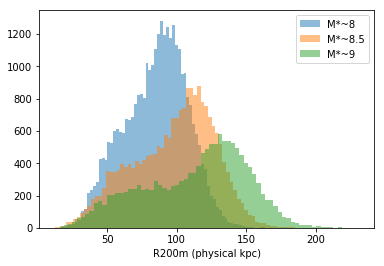

In [27]:
plt.hist(R200m_8/h, bins=70, label='M*~8', alpha=0.5)
plt.hist(R200m_8p5/h, bins=70, label='M*~8.5', alpha=0.5)
plt.hist(R200m_9/h, bins=70, label='M*~9', alpha=0.5)
plt.xlabel('R200m (physical kpc)')
plt.legend()
plt.show()

R200 in physical (kpc/h)

In [42]:
print('mean R_200: {0} (M8), {1} (M9)'.format(np.mean(R200m_8/h),
                                              np.mean(R200m_9/h)))

mean R_200: 84.5461465058 (M8), 113.442980876 (M9)


In [43]:
print('mean R_vir: {0} (M8), {1} (M9)'.format(np.mean(m_star8_catalog['halo_rvir']*a/h),
                                              np.mean(m_star9_catalog['halo_rvir']*a/h)))

mean R_vir: 0.0766416192055 (M8), 0.102765128016 (M9)


In [49]:
print('mean M_200m: {0} (M8), {1} (M9)'.format(np.mean(np.log10(M200m_8/h)),
                                              np.mean(np.log10(M200m_9/h))))

mean M_200m: 10.9073448563 (M8), 11.2521900318 (M9)
